In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
from deeplabv3 import model
import torchvision.transforms as T
import numpy as np

In [6]:
END_WITH_LOCAL = 'DEEPLABv3'

os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"

NOTEBOOK_DIR = os.getcwd()
print(f"NOTEBOOK_DIR: {NOTEBOOK_DIR}")

# Simple validation
if not (NOTEBOOK_DIR.endswith('/content') or NOTEBOOK_DIR.endswith(END_WITH_LOCAL)):
    raise ValueError(f"Expected to be in .../{END_WITH_LOCAL} or .../content directory, but got: {NOTEBOOK_DIR}")

BASE_DIR = os.path.join(NOTEBOOK_DIR, '..', '..', '..')
os.listdir(BASE_DIR)

NOTEBOOK_DIR: /Volumes/HP_P900/Users/tungnguyen/Library/CloudStorage/GoogleDrive-nguyenlamtungthptltt@gmail.com/My Drive/Third-Year/DeepLearning/bubble-segmentation-final-deep-learning/code/bubble-detection/DEEPLABv3


['.DS_Store',
 'Dockerfile',
 'environments',
 'output',
 'code',
 'models',
 'README.md',
 '.dockerignore',
 '.gitignore',
 '.git',
 '.vscode',
 'data']

In [7]:
NUM_EPOCHS= 10
BATCH_SIZE= 8

IMAGE_DIR = os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images')
MASK_DIR  = os.path.join(BASE_DIR, 'data/MangaSegmentation/jsons_processed')
DEEPLABv3_DATA_DIR = os.path.join(BASE_DIR, 'data/MangaSegmentation/DEEPLABv3_data')
os.makedirs(DEEPLABv3_DATA_DIR, exist_ok=True)
TRAIN_JSON_FILE = os.path.join(DEEPLABv3_DATA_DIR, "train.json")
VAL_JSON_FILE = os.path.join(DEEPLABv3_DATA_DIR, "val.json")
DEEPLABv3_MODEL_DIR = os.path.join(BASE_DIR, 'models/bubble-detection/DEEPLABv3')
os.makedirs(DEEPLABv3_MODEL_DIR, exist_ok=True)
DEEPLABv3_MODEL_FILE = os.path.join(DEEPLABv3_MODEL_DIR, 'best_deeplabv3_model.pth')
EX_JSON_FILE= os.path.join(BASE_DIR,'data/MangaSegmentation/jsons_processed/Arisa.json')
EX_IMG_FILE= os.path.join(BASE_DIR, 'data/Manga109_released_2023_12_07/images/AisazuNihaIrarenai/029.jpg')

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


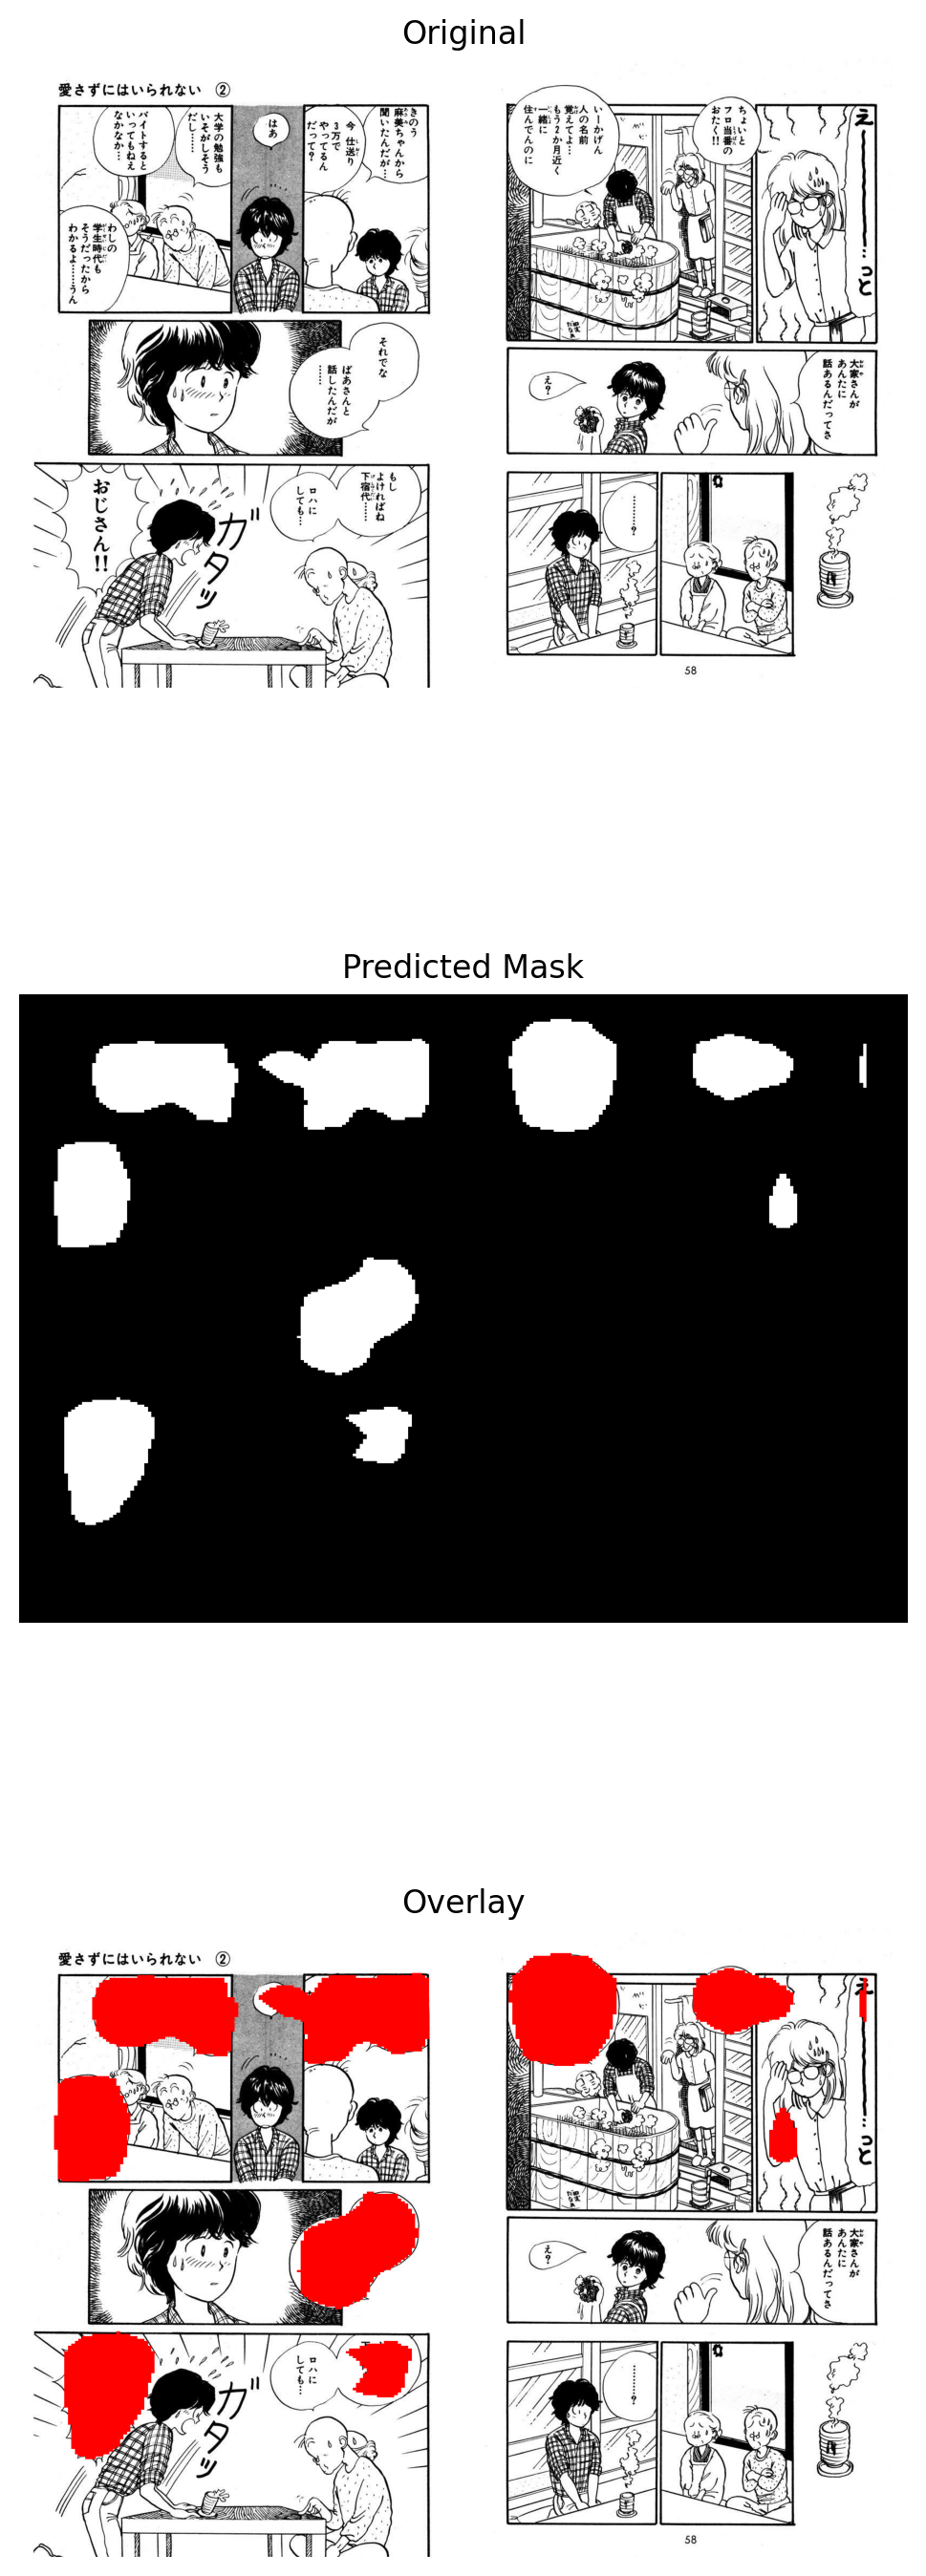

In [9]:
state_dict = torch.load(DEEPLABv3_MODEL_FILE, 
                        map_location=torch.device(device))

if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict, strict=False)
model.eval()

img =  cv2.imread(EX_IMG_FILE)
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

resized = cv2.resize(img, (256, 256)) 

transform = T.Compose([
    T.ToTensor(),
])

input_tensor = transform(resized).unsqueeze(0)  # [1, C, H, W]

with torch.no_grad():
    output = model(input_tensor)  # DeepLabV3 trả dict {"out": tensor}
    pred = output['out']          # [1, 1, H, W] nếu binary
    pred = torch.sigmoid(pred)    # nếu binary segmentation
    pred = pred.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]

# threshold mask
mask = (pred > 0.5).astype(np.uint8)

# resize về kích thước ảnh gốc
mask_full = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# tạo overlay màu đỏ
overlay = img.copy()
overlay[mask_full == 1] = (255, 0, 0)

# visualize
plt.figure(figsize=(6,18), dpi=200)
plt.subplot(3,1,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(3,1,2)
plt.title("Predicted Mask")
plt.imshow(mask_full, cmap="gray")
plt.axis("off")

plt.subplot(3,1,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.savefig("inference.png")
plt.show()

